In [1]:
import numpy as np
import matplotlib.pyplot as plt
from group_lasso import LogisticGroupLasso
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import cvxpy as cp
import warnings
from joblib import Parallel, delayed
import pandas as pd
import seaborn as sns

# Suppress all warnings
warnings.filterwarnings("ignore")

## Functions for Debiasing

In [2]:
def data_gen(n_samples,grp=1,snr_val=1):
    n_groups = 10
    per_group = 5
    group_sizes = [per_group] * n_groups
    
    n_relevant_groups = n_groups//3 # first n_relevant_groups groups have non-zero effect
    p = sum(group_sizes)
    
    # Generate X with group structure
    X = []
    true_coefs = []
    
    for i, size in enumerate(group_sizes):
        cov = 0.8 # Correlation within groups
        cov_matrix = cov * np.ones((size, size)) + (1 - cov) * np.eye(size)
        # print(cov_matrix)
        group_X = np.random.multivariate_normal(mean=np.zeros(size), cov=cov_matrix, size=n_samples)
        # print(group_X)
        X.append(group_X)
        # Assign nonzero coefficients to only relevant groups
        if i < n_relevant_groups:
            true_coefs.append(np.random.uniform(0.5, 2, size))
        else:
            true_coefs.append(np.zeros(size))
    
    # Design matrix
    X = np.hstack(X)
    true_coefs = np.hstack(true_coefs)
    beta_0 = true_coefs

    groups = []
    for i in range(n_groups):
        groups.append(np.ones(per_group).astype(int)+i)
    groups = np.array(groups).flatten()
    
    change_snr = np.where(groups == grp)
    beta_0[change_snr] = beta_0[change_snr] * snr_val

    
    # Standardize X
    X = (X-np.mean(X, axis=0))/(np.std(X, axis=0))
    
    pr = 1/(1+np.exp(-X @ true_coefs)) # pass through the inv-logit function
    
    # Generate binary outcomes
    y = np.random.binomial(1, pr)

    
    return X, y, groups, beta_0, p

In [80]:
def sigma_hat_matr(X, beta_hat):
    n, p = X.shape
    sigma_hat = 0
    w_arr = []
    for i in range(n):
        exp_term = np.exp(X[i,:].reshape(1,p) @ beta_hat)
        w_i = np.sqrt(exp_term/((1+exp_term)**2))
        w_arr.append(w_i[0][0])
        sigma_hat += (X[i,:].reshape(p,1) @ X[i,:].reshape(1,p) * (w_i**2))

    sigma_hat = (1/n) * sigma_hat 
    return sigma_hat, w_arr


def solve_gamma_hat(X_beta, lmbda):
    n, p = X_beta.shape
    Gamma_hat = np.zeros((p, p - 1))

    for j in range(p):
        Xj = X_beta[:, j]
        X_minus_j = np.delete(X_beta, j, axis=1)

        gamma_j = cp.Variable(p - 1)

        residual = Xj - X_minus_j @ gamma_j
        loss = (1 / n) * cp.sum_squares(residual)
        reg = 2 * lmbda * cp.norm1(gamma_j)
        objective = cp.Minimize(loss + reg)

        # Solve
        prob = cp.Problem(objective)
        prob.solve()

        Gamma_hat[j, :] = gamma_j.value

    return Gamma_hat

def compute_theta_tau2(X_beta, Gamma_hat):
    n, p = X_beta.shape
    Theta_hat = np.zeros((p, p))
    tau2_hat = np.zeros(p)

    for j in range(p):
        # Extract X_j and X_-j
        Xj = X_beta[:, j]
        X_minus_j = np.delete(X_beta, j, axis=1)
        gamma_j = Gamma_hat[j, :]                

        r_j = Xj - X_minus_j.dot(gamma_j)

        tau2_hat[j] = (Xj.T.dot(r_j)) / n

        theta_j = np.zeros(p)
        theta_j[j] = 1.0
        
        theta_j[np.arange(p) != j] = -gamma_j
        
        Theta_hat[:, j] = theta_j / tau2_hat[j]

    return Theta_hat, tau2_hat

# def ridge_inverse(sigma_hat, lambda_ridge=1e-4):
#     p = sigma_hat.shape[0]
#     identity = np.eye(p)
#     theta_hat = np.linalg.inv(sigma_hat + lambda_ridge * identity)
#     return theta_hat

def normalization(X,y,debiased_b,beta_0,Theta_hat,a):
    n, p = X.shape

    beta_0 = beta_0.reshape(p,1)
    a = a.reshape(p,1)

    num = np.sqrt(n) * ((a.T @ (debiased_b - beta_0))[0][0])

    inner = 0
    for i in range(n):
        exp_term = np.exp(X[i,:].reshape(1,p) @ beta_hat)
        inner += (X[i,:].reshape(p,1) @ X[i,:].reshape(1,p)) * (((-y[i][0] + (exp_term/(1+exp_term)))[0][0])**2)

    inner = (1/n) * inner
    
    den = np.sqrt(a.T @ (Theta_hat @ inner @ Theta_hat.T) @ a) 

    normal_val = num/den
    
    return normal_val

    

# QQ-Plots

In [ ]:
n = 2000 # Number of samples
active = 3 # Number of non-zero groups (signal groups)

grp = 1 # Change group to analyze for QQ plots (Signal groups: 1,2,3 ; Noise groups: 4,...,10)

n_sims = 100 # Change number of simulations


a = np.zeros(p)
grp_indx = np.where(groups==grp) # Pick group
a[grp_indx] = np.sqrt(1/5)  

normal_arr = []
true_beta_arr = []

beta_hat_arr = []
debiased_arr = []



for i in range(n_sims):
    X, y, groups, beta_0, p = data_gen(n)

    true_beta_arr.append(beta_0)
    # print("Groups:", groups)
    
    
    gl = LogisticGroupLasso(groups=groups)
    
    # Uncomment for grid search. 100 grid points.
    # grid = {'group_reg':np.logspace(-2, -0.5, 100),'l1_reg':[0]}
    
    grid = {'group_reg':[0.05],'l1_reg':[0]}
    
    GS = GridSearchCV(estimator = gl, param_grid=grid)
    GS.fit(X, y)
    
    model = GS.best_estimator_
    beta_hat = model.coef_[:,0].copy()

    y = y.reshape((np.shape(y)[0], 1))
    beta_hat = beta_hat.reshape(np.shape(beta_hat)[0],1)
    
    beta_hat_arr.append(beta_hat)


    # Debiasing

    sigma_hat, w_arr = sigma_hat_matr(X, beta_hat)

    W_matr = np.diag(w_arr)
    X_beta = W_matr @ X
    
    Gamma_hat = solve_gamma_hat(X_beta, lmbda=np.sqrt(np.log(p)/n)*np.max(np.abs(X)))
    Theta_hat, tau2_hat = compute_theta_tau2(X_beta, Gamma_hat)
        
    debiased_b = beta_hat - Theta_hat @ ((1/n) * (X.T @ (-y + (1/(1 + np.exp(-X @ beta_hat))))))

    debiased_arr.append(debiased_b)

    normal_val = normalization(X,y,debiased_b,beta_0,Theta_hat,a)
    normal_arr.append(normal_val[0,0])



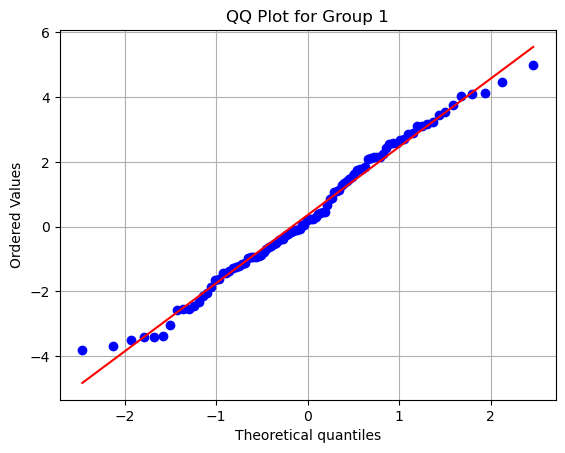

In [16]:
import matplotlib.pyplot as plt
import scipy.stats as stats

stats.probplot(normal_arr, dist="norm", plot=plt)
plt.title("QQ Plot for Group "+ str(grp))
plt.grid(True)
plt.show()

## SNR Plots

In [ ]:
n = 1000
active = 3 # Number of non-zero groups (signal groups)

n_sims = 50 # Change number of simulations

grp = 1 # Change group we select to test for power vs. SNR plots (0 is the first group)

j = 0 # Change specific feature within the group we select for power vs. SNR plots 
      #(e.g. first index j=0 of the 5 features composing selected group J)
a = np.zeros(p)
a[j] = 1


snr_vec = [0, 0.1, 0.25, 0.5, 0.75, 1.0, 10.0]

power = []


for snr_val in snr_vec:
    reject = 0
    for _ in range(n_sims):
        X, y, groups, beta_0, p = data_gen(n,grp,snr_val)
        
        gl = LogisticGroupLasso(groups=groups)
        
        # Uncomment for grid search. 100 grid points.
        # grid = {'group_reg':np.logspace(-2, -0.5, 100),'l1_reg':[0]}
        
        grid = {'group_reg':[0.05],'l1_reg':[0]}
        
        GS = GridSearchCV(estimator = gl, param_grid=grid)
        GS.fit(X, y)
        
        model = GS.best_estimator_
        beta_hat = model.coef_[:,0].copy()
    
        y = y.reshape((np.shape(y)[0], 1))
        beta_hat = beta_hat.reshape(np.shape(beta_hat)[0],1)
    
    
        # Debiasing
    
        sigma_hat, w_arr = sigma_hat_matr(X, beta_hat)
    
        W_matr = np.diag(w_arr)
        X_beta = W_matr @ X
        
        Gamma_hat = solve_gamma_hat(X_beta, lmbda=np.sqrt(np.log(p)/n)*np.max(np.abs(X)))
        Theta_hat, tau2_hat = compute_theta_tau2(X_beta, Gamma_hat)
    
        debiased_b = beta_hat - Theta_hat @ ((1/n) * (X.T @ (-y + (1/(1 + np.exp(-X @ beta_hat))))))

        beta_0 = beta_0.reshape(p,1)
        a = a.reshape(p,1)
    
        
        inner = 0
        for i in range(n):
            exp_term = np.exp(X[i,:].reshape(1,p) @ beta_hat)
            inner += (X[i,:].reshape(p,1) @ X[i,:].reshape(1,p)) * (((-y[i][0] + (exp_term/(1+exp_term)))[0][0])**2)
    
        inner = (1/n) * inner

        SE_Jj = np.sqrt(a.T @ (Theta_hat @ inner @ Theta_hat.T) @ a) 
        
        test_stat_Jj = (debiased_b[j] - 0) / (SE_Jj / np.sqrt(n))

        if np.abs(test_stat_Jj) > 1.96:
            reject += 1
            
    power.append(reject/n_sims)




In [46]:
print("SNR:", snr_vec)
print("Power:", power)

SNR: [0, 0.1, 0.25, 0.5, 0.75, 1.0, 10.0]
Power: [0.02, 0.12, 0.88, 1.0, 1.0, 1.0, 1.0]


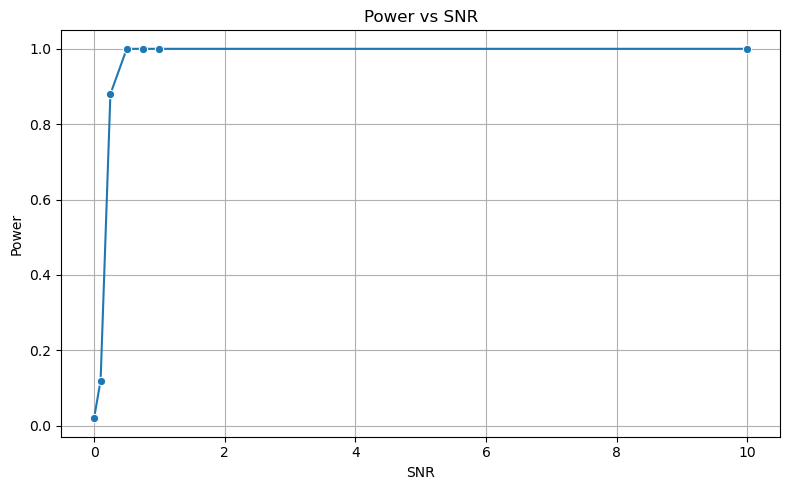

In [51]:
# Make plots

df = pd.DataFrame({
    'SNR': snr_vec,
    'Power': power
})
plt.figure(figsize=(8, 5))

sns.lineplot(data=df, x='SNR', y='Power', marker='o')

# Add labels and grid
plt.xlabel('SNR')
plt.ylabel('Power')
plt.title('Power vs SNR')
plt.grid(True)
plt.tight_layout()
plt.show()

# Method Proposal Simulations

In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from graspologic.embed import OmnibusEmbed
import matplotlib.pyplot as plt
from group_lasso import LogisticGroupLasso
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

In [288]:
import networkx as nx
import numpy as np

def generate_brain_graphs(n_graphs_per_class=50):
    
    n_nodes = 40
    cluster_size = 10
    clusters = {
        'A': range(0, 10),
        'B': range(10, 20),
        'C': range(20, 30),
        'D': range(30, 40)
    }
    
    # Define intra-cluster and inter-cluster probabilities
    healthy_probs = {'A': 0.8, 'B': 0.8, 'C': 0.8, 'D': 0.8}
    ad_probs = {'A': 0.4, 'B': 0.6, 'C': 0.8, 'D': 0.8}
    inter_cluster_prob = 0.03

    graphs = []
    labels = []

    def add_edges(G, nodes, prob):
        for i in nodes:
            for j in nodes:
                if i < j and np.random.rand() < prob:
                    G.add_edge(i, j)

    for _ in range(n_graphs_per_class):
        # Healthy graph
        G_healthy = nx.Graph()
        G_healthy.add_nodes_from(range(n_nodes))

        # Add intra-cluster edges
        for cluster, nodes in clusters.items():
            add_edges(G_healthy, nodes, healthy_probs[cluster])

        # Add inter-cluster edges
        for c1, nodes1 in clusters.items():
            for c2, nodes2 in clusters.items():
                if c1 < c2:
                    for i in nodes1:
                        for j in nodes2:
                            if np.random.rand() < inter_cluster_prob:
                                G_healthy.add_edge(i, j)

        graphs.append(G_healthy)
        labels.append(0)

    for _ in range(n_graphs_per_class):
        # AD graph
        G_ad = nx.Graph()
        G_ad.add_nodes_from(range(n_nodes))

        # Add intra-cluster edges with altered probabilities
        for cluster, nodes in clusters.items():
            add_edges(G_ad, nodes, ad_probs[cluster])

        # Add inter-cluster edges (same as healthy)
        for c1, nodes1 in clusters.items():
            for c2, nodes2 in clusters.items():
                if c1 < c2:
                    for i in nodes1:
                        for j in nodes2:
                            if np.random.rand() < inter_cluster_prob:
                                G_ad.add_edge(i, j)

        graphs.append(G_ad)
        labels.append(1)

    return graphs, labels


In [289]:
graphs, labels = generate_brain_graphs(50)
print(labels)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


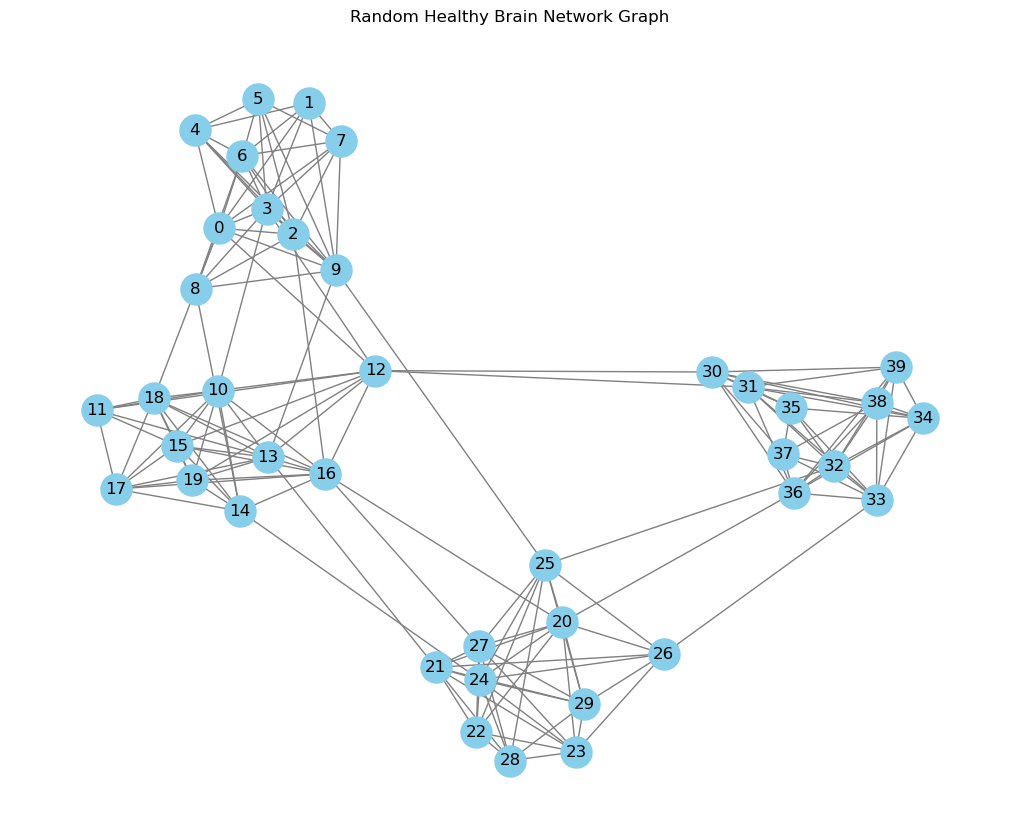

In [290]:
random_healthy_graph = graphs[10]

# Plot the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(random_healthy_graph)  # Layout for visual clarity
nx.draw(random_healthy_graph, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500)
plt.title("Random Healthy Brain Network Graph")
plt.show()

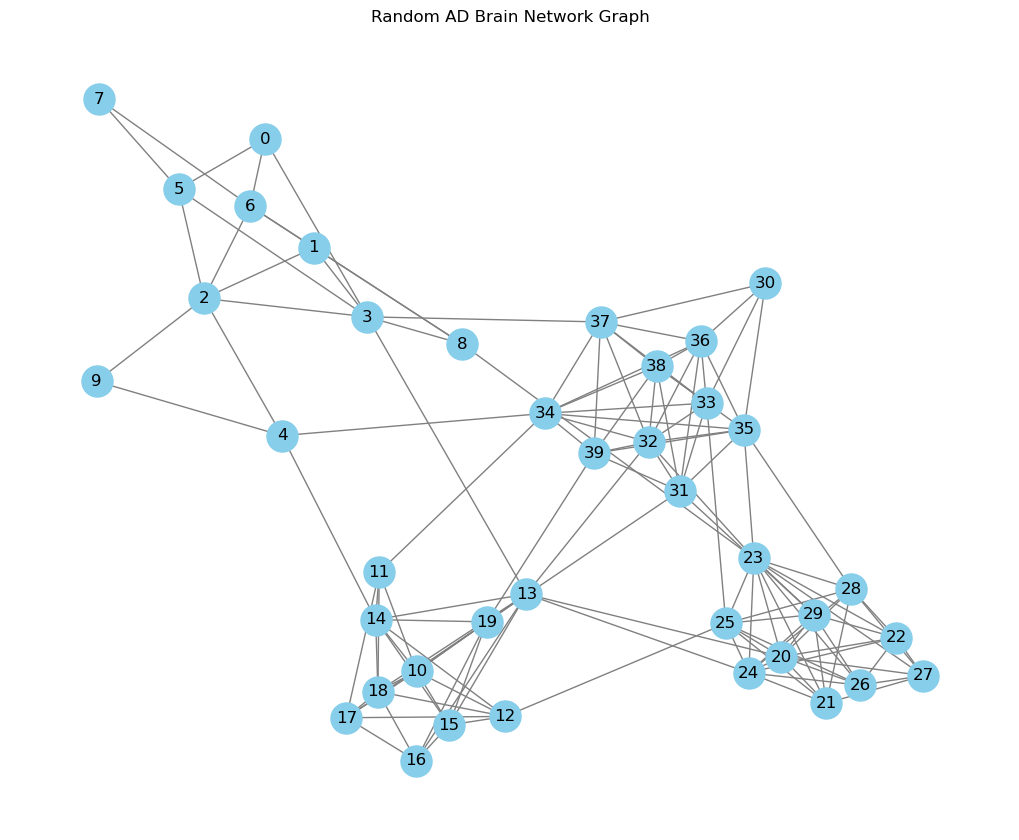

In [291]:
random_AD_graph = graphs[90]

# Plot the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(random_AD_graph)  # Layout for visual clarity
nx.draw(random_AD_graph, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500)
plt.title("Random AD Brain Network Graph")
plt.show()

In [292]:
embedder = OmnibusEmbed(n_components=5)

X_train = embedder.fit_transform(graphs) # Tensor: Number samples x Number nodes x Embed Space
print(np.shape(X_train))

(100, 40, 5)


In [324]:
from sklearn.preprocessing import StandardScaler


X_flat = X_train.reshape(X_train.shape[0], -1)
y = np.array(labels)

scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat) # Standardize data!!!


groups = np.repeat(np.arange(4), 50) + 1

gl = LogisticGroupLasso(groups=groups)

# grid = {'group_reg':np.logspace(-3, -0.5, 100),'l1_reg':[0]}
grid = {'group_reg':[0.01],'l1_reg':[0]}

GS = GridSearchCV(estimator = gl, param_grid=grid)
GS.fit(X_flat, y)

model = GS.best_estimator_
coefficients = model.coef_[:,1]

In [325]:
import decimal

print(GS.best_params_)

j = 0
for i in ['A', 'B', 'C', 'D']:
    j += 1
    vals = coefficients[np.where(groups == j)]
    norm_val = decimal.Decimal(np.linalg.norm(vals))
    print(f"||β_{i}||_₂ = {norm_val:.4f}")
    

{'group_reg': 0.01, 'l1_reg': 0}
||β_A||_₂ = 0.4107
||β_B||_₂ = 0.1410
||β_C||_₂ = 0.0000
||β_D||_₂ = 0.0000


In [327]:
y = y.reshape((np.shape(y)[0], 1))
X = X_flat

beta_hat = coefficients.reshape(np.shape(coefficients)[0],1)
sigma_hat, w_arr = sigma_hat_matr(X, beta_hat)

W_matr = np.diag(w_arr)
X_beta = W_matr @ X
    
Gamma_hat = solve_gamma_hat(X_beta, lmbda=np.sqrt(np.log(p)/n)*np.max(np.abs(X)))
Theta_hat, tau2_hat = compute_theta_tau2(X_beta, Gamma_hat)
        
debiased_b = beta_hat - Theta_hat @ ((1/n) * (X.T @ (-y + (1/(1 + np.exp(-X @ beta_hat))))))

In [338]:
print(np.mean(debiased_b[0:50]))
print(np.mean(debiased_b[50:100]))
print(np.mean(debiased_b[100:150]))
print(np.mean(debiased_b[150:200]))

-0.4895964364249993
-0.19474412557009746
0.005521950924124077
0.01672917238723811
